## Import Necessary Module

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [33]:
IMG_SIZE = 224
CHANNEL = 3
EPOCHS = 20
BATCH_SIZE = 32

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory('C:\\Users\\thesu\\Desktop\\sample_project_1\\mammals',
                                                              shuffle=True,
                                                              image_size=(224,224),
                                                              batch_size=32
                                                              )

Found 13751 files belonging to 45 classes.


In [6]:
class_name = dataset.class_names

### Let plot some Images

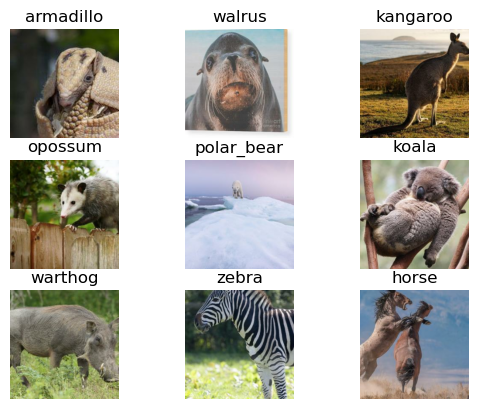

In [14]:
for image,label in dataset.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype('uint8'))
        plt.title(class_name[label[i]])
        plt.axis('off')

### Split our data into batches

In [15]:
def create_data_batch(dataset,train_size=0.8,val_size=0.1,test_size=0.1,shuffle=True,shuffle_size=1000):
    data_len = len(dataset)
    if shuffle:
        dataset = dataset.shuffle(shuffle_size,seed=12)
    train_size = int(data_len*train_size)
    val_size = int(data_len*val_size)
    
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)
    
    return train_ds,test_ds,val_ds

In [16]:
train_ds,test_ds,val_ds = create_data_batch(dataset)

In [19]:
len(train_ds),len(test_ds),len(val_ds)

(344, 43, 43)

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### rescale resize

In [43]:
rescale_resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

###  Pre Trained Model (Mobilenetv2)

In [44]:
pre_trained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet",
    pooling='max',
    classes=45,
    classifier_activation="softmax",
)

In [45]:
for layers in pre_trained_model.layers:
    layers.trainable=False

### Model Building

In [49]:
CHANNELS =3
INPUT_SHAPE =(BATCH_SIZE,IMG_SIZE,IMG_SIZE,CHANNELS)

model= tf.keras.Sequential([
    rescale_resize,
    pre_trained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(45,activation="softmax")
        
])

model.build(INPUT_SHAPE)

In [50]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (32, 224, 224, 3)         0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten_9 (Flatten)         (32, 1280)                0         
                                                                 
 dense_17 (Dense)            (32, 100)                 128100    
                                                                 
 dense_18 (Dense)            (32, 45)                  4545      
                                                                 
Total params: 2390629 (9.12 MB)
Trainable params: 132645 (518.14 KB)
Non-trainable params: 2257984 (8.61 MB)
__________

In [53]:
model.compile(optimizer='adam',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
             metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy',patience=2)

#### Fit and Train our Model

In [54]:
histroy = model.fit(train_ds,validation_data=val_ds,epochs=EPOCHS,callbacks=[callback])

Epoch 1/20
344/344 [==============================] - 398s 1s/step - loss: 1.3961 - accuracy: 0.6352 - val_loss: 0.5958 - val_accuracy: 0.8307
Epoch 2/20
344/344 [==============================] - 330s 959ms/step - loss: 0.5339 - accuracy: 0.8456 - val_loss: 0.4276 - val_accuracy: 0.8801
Epoch 3/20
344/344 [==============================] - 389s 1s/step - loss: 0.3635 - accuracy: 0.8909 - val_loss: 0.3480 - val_accuracy: 0.8961
Epoch 4/20
344/344 [==============================] - 354s 1s/step - loss: 0.2813 - accuracy: 0.9144 - val_loss: 0.2715 - val_accuracy: 0.9230
Epoch 5/20
344/344 [==============================] - 385s 1s/step - loss: 0.2086 - accuracy: 0.9338 - val_loss: 0.2347 - val_accuracy: 0.9382
Epoch 6/20
344/344 [==============================] - 396s 1s/step - loss: 0.1554 - accuracy: 0.9486 - val_loss: 0.1799 - val_accuracy: 0.9499
Epoch 7/20
344/344 [==============================] - 429s 1s/step - loss: 0.1215 - accuracy: 0.9597 - val_loss: 0.2135 - val_accuracy: 0.9

In [55]:
model.evaluate(test_ds)

43/43 [==============================] - 85s 993ms/step - loss: 0.1042 - accuracy: 0.9731


[0.10417145490646362, 0.9731104373931885]

#### Plot Val and Training (ACC,LOSS)

Text(0.5, 1.0, 'training and validation loss')

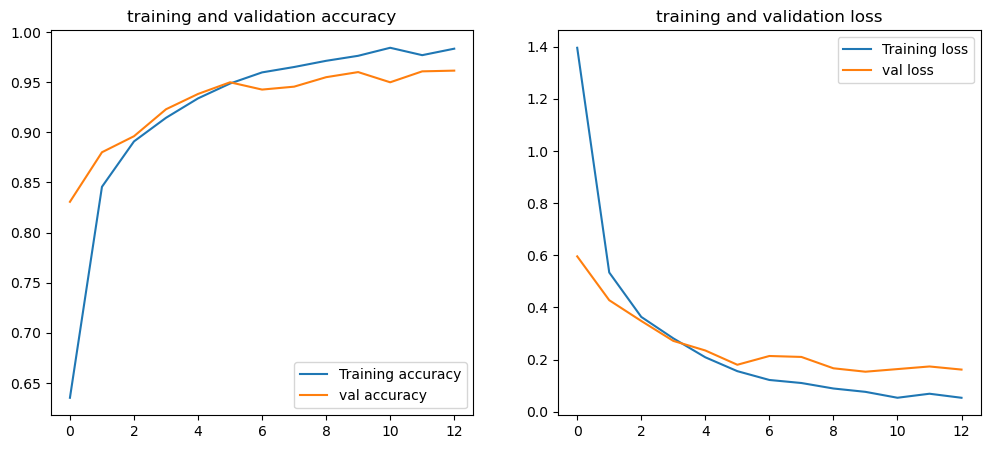

In [58]:
acc = histroy.history["accuracy"]
loss = histroy.history['loss']
val_acc = histroy.history["val_accuracy"]
val_loss = histroy.history['val_loss']


# Accuracy for training and val
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(range(13),acc,label="Training accuracy")
plt.plot(range(13),val_acc,label="val accuracy")
plt.legend()
plt.title("training and validation accuracy")

# loss for val and training
plt.subplot(1,2,2)
plt.plot(range(13),loss,label="Training loss")
plt.plot(range(13),val_loss,label="val loss")
plt.legend()
plt.title("training and validation loss")

#### save and load our model 

In [59]:
model.save('mammals V1 model.keras')

In [1]:
from keras.models import load_model

In [2]:
mammal_model = load_model('mammals V1 model.keras')

#### lets play and predict with Google images

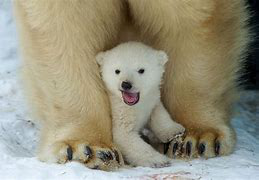

In [166]:
from PIL import Image

img = Image.open('polar bear.jpg')
img

In [167]:
img = tf.keras.preprocessing.image.img_to_array(img)

img = np.expand_dims(img,axis=0)

In [168]:
predicted = mammal_model.predict(img)

1/1 [==============================] - 0s 111ms/step


In [169]:
class_name[np.argmax(predicted)]

'polar_bear'

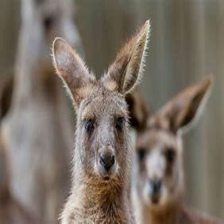

In [11]:
from PIL import Image

img = Image.open('kangaroo.jpg').resize((224,224))
img

In [12]:
img = tf.keras.preprocessing.image.img_to_array(img)

img = np.expand_dims(img,axis=0)

predicted = mammal_model.predict(img)

class_name[np.argmax(predicted)]

1/1 [==============================] - 1s 1s/step


'kangaroo'

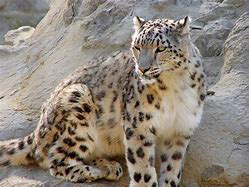

In [13]:
from PIL import Image

img = Image.open('snow lepoard.jpg')
img

In [14]:
img = tf.keras.preprocessing.image.img_to_array(img)

img = np.expand_dims(img,axis=0)

predicted = mammal_model.predict(img)

class_name[np.argmax(predicted)]

1/1 [==============================] - 1s 960ms/step


'snow_leopard'

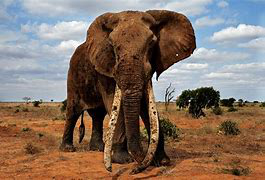

In [15]:
from PIL import Image

img = Image.open('eliphant.jpg')
img

In [16]:
img = tf.keras.preprocessing.image.img_to_array(img)

img = np.expand_dims(img,axis=0)

predicted = mammal_model.predict(img)

class_name[np.argmax(predicted)]

1/1 [==============================] - 0s 38ms/step


'african_elephant'

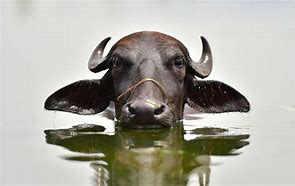

In [17]:
from PIL import Image

img = Image.open('water buffalo.jpg')
img

In [18]:
img = tf.keras.preprocessing.image.img_to_array(img)

img = np.expand_dims(img,axis=0)

predicted = mammal_model.predict(img)

class_name[np.argmax(predicted)]

1/1 [==============================] - 0s 40ms/step


'water_buffalo'

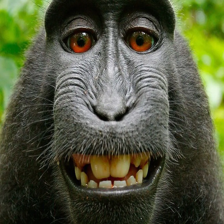

In [20]:
from PIL import Image

img = Image.open('monkey.webp').resize((224,224))
img

In [21]:
img = tf.keras.preprocessing.image.img_to_array(img)

img = np.expand_dims(img,axis=0)

predicted = mammal_model.predict(img)

class_name[np.argmax(predicted)]

1/1 [==============================] - 0s 34ms/step


'baboon'

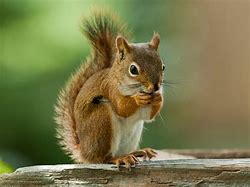

In [23]:
from PIL import Image

img = Image.open('sq1.jpg')
img

In [24]:
img = tf.keras.preprocessing.image.img_to_array(img)

img = np.expand_dims(img,axis=0)

predicted = mammal_model.predict(img)

class_name[np.argmax(predicted)]

1/1 [==============================] - 0s 38ms/step


'squirrel'

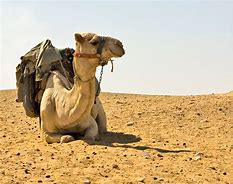

In [25]:
from PIL import Image

img = Image.open('camel.jpg')
img

In [26]:
img = tf.keras.preprocessing.image.img_to_array(img)

img = np.expand_dims(img,axis=0)

predicted = mammal_model.predict(img)

class_name[np.argmax(predicted)]

1/1 [==============================] - 0s 37ms/step


'camel'

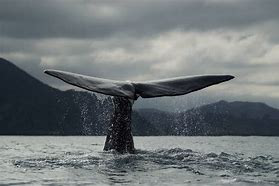

In [27]:
from PIL import Image

img = Image.open('blue whale.jpg')
img

In [28]:
img = tf.keras.preprocessing.image.img_to_array(img)

img = np.expand_dims(img,axis=0)

predicted = mammal_model.predict(img)

class_name[np.argmax(predicted)]

1/1 [==============================] - 0s 38ms/step


'blue_whale'

It look